# 実行について
上から順に実験コード前まで実行していきましょう。

# 目次

- [誤差関数](#誤差関数)
- [活性化関数](#活性化関数)
- [最適化](#最適化)
- [CNN util](#CNN-util)
- [レイヤ](#レイヤ)
- [レイヤマネージャ](#レイヤマネージャ)
- [実験コード](#実験コード)

#cupyのインストールと確認

In [3]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   8633      0 --:--:-- --:--:-- --:--:--  8633
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 369.6MB 47kB/s 
+ set +ex
Installation succeeded!


In [4]:
!python -c 'import chainer; chainer.print_runtime_info()'

/usr/local/lib/python3.6/dist-packages/chainer/backends/cuda.py:147: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cudnn).
  'cuDNN is not enabled.\n'
/usr/local/lib/python3.6/dist-packages/chainer/_environment_check.py:73: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda100) version 8.0.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda100>=7.4.0,<8.0.0'

See the following page for more details:
  https://docs-cupy.chainer.org/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))
/usr/local/lib/python3.6/dist-packages/chainer/_environment_check.py:91: UserWarning: 
--------------------------------------------------------------------------------
Mu

#CPUの数を確認

In [5]:
import os
os.cpu_count()

2

# CPU/GPU切り替え用クラス

In [6]:
import numpy as np
import cupy as cp


class Switch():
    def __init__(self, *args, mode="cpu", **kwds):
        if mode == "cpu":
            self.calculator = np
        elif mode == "gpu":
            self.calculator = cp

# 誤差関数
[目次へ戻る](#目次)

In [7]:
class Error(Switch):
    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)
        self.error = 0
    
    
    def forward(self, *args, **kwds):
        raise NotImplemented
    

    def backward(self, *args, **kwds):
        raise NotImplemented

    
    def total_error(self, *args, **kwds):
        return self.calculator.sum(self.error)/self.error.size


class SquareError(Error):
    def forward(self, y, t, *args, **kwds):
        self.error = 0.5 * (y - t)**2
        return self.error
    
    
    def backward(self, y, t, *args, **kwds):
        return y - t


class BinaryCrossEntropy(Error):
    def forward(self, y, t, *args, eps=1e-8, **kwds):
        self.error = (- t*self.calculator.log(y+eps)
                      - (1 - t)*self.calculator.log(1-y+eps))
        return self.error
    
    
    def backward(self, y, t, *args, eps=1e-8, **kwds):
        return (y - t) / (y*(1 - y) + eps)
    

class CrossEntropy(Error):
    def forward(self, y, t, *args, eps=1e-8, **kwds):
        self.error = - t*self.calculator.log(y+eps)
        return self.error
    
    
    def backward(self, y, t, *args, eps=1e-8, **kwds):
        return - t/(y+eps)

In [8]:
import string


_err_dic = {"square": SquareError,
            "binary": BinaryCrossEntropy,
            "cross": CrossEntropy,
           }


def get_err(err_name, *args, **kwds):
    name = err_name.lower().translate(str.maketrans( '', '',string.punctuation))
    if name in _err_dic.keys():
        errfunc = _err_dic[name](*args, **kwds)
    else:
        raise ValueError(name + ": Unknown error function")

    return errfunc

# 活性化関数
[目次へ戻る](#目次)

In [9]:
class Activator(Switch):
    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)

    def forward(self, *args, **kwds):
        raise NotImplemented


    def backward(self, *args, **kwds):
        raise NotImplemented


    def update(self, *args, **kwds):
        raise NotImplemented


class step(Activator):
    def forward(self, x, *args, **kwds):
        return self.calculator.where(x > 0, 1, 0)
    

    def backward(self, x, *args, **kwds):
        return self.calculator.zeros_like(x)    


class identity(Activator):
    def forward(self, x, *args, **kwds):
        return x
    

    def backward(self, x, *args, **kwds):
        return self.calculator.ones_like(x)


class bentIdentity(Activator):
    def forward(self, x, *args, **kwds):
        return 0.5*(self.calculator.sqrt(x**2 + 1) - 1) + x
    

    def backward(self, x, *args, **kwds):
        return 0.5*x/self.calculator.sqrt(x**2 + 1) + 1


class hardShrink(Activator):
    def __init__(self, lambda_=0.5, *args, **kwds):
        super().__init__(*args, **kwds)
        self.lambda_ = lambda_


    def forward(self, x, *args, **kwds):
        return self.calculator.where(
            (-self.lambda_ <= x) & (x <= self.lambda_), 0, x)
    

    def backward(self, x, *args, **kwds):
        return self.calculator.where(
            (-self.lambda_ <= x) & (x <= self.lambda_), 0, 1)


class softShrink(Activator):
    def __init__(self, lambda_=0.5, *args, **kwds):
        super().__init__(*args, **kwds)
        self.lambda_ = lambda_


    def cpu_forward(self, x, *args, **kwds):
        return self.calculator.where(
            x < -self.lambda_,
            x + self.lambda_,
            self.calculator.where(x > self.lambda_, x - self.lambda_, 0))


    def backward(self, x, *args, **kwds):
        return self.calcolator.where(
            (-self.lambda_ <= x) & (x <= self.lambda_), 0, 1)


class threshold(Activator):
    def __init__(self, threshold, value, *args, **kwds):
        super().__init__(*args, **kwds)
        self.threshold = threshold
        self.value = value


    def forward(self, x, *args, **kwds):
        return self.calculator.where(x > self.threshold, x, self.value)
    

    def backward(self, x, *args, **kwds):
        return self.calculator.where(x > self.threshold, 1, 0)
    

class sigmoid(Activator):
    def forward(self, x, *args, **kwds):
        return 1/(1 + self.calculator.exp(-x))
    

    def backward(self, x, y, *args, **kwds):
        return y*(1 - y)


class hardSigmoid(Activator):
    def forward(self, x, *args, **kwds):
        return self.calculator.clip(0.2*x + 0.5, 0, 1)
    

    def backward(self, x, *args, **kwds):
        return self.calculator.where((x > 2.5) | (x < -2.5), 0, 0.2)
    

class logSigmoid(Activator):
    def forward(self, x, *args, **kwds):
        return -self.calculator.logaddexp(-x, 0)


    def backward(self, x, *args, **kwds):
        return 1/(1 + self.calculator.exp(x))
    

class act_tanh(Activator):
    def forward(self, x, *args, **kwds):
        return self.calculator.tanh(x)
    

    def backward(self, x, *args, **kwds):
        return 1 - self.calculator.tanh(x)**2
    

class hardtanh(Activator):
    def forward(self, x, *args, **kwds):
        return self.calculator.clip(x, -1, 1)
    

    def backward(self, x, *args, **kwds):
        return self.calculator.where((-1 <= x) & (x <= 1), 1, 0)
    

class tanhShrink(Activator):
    def forward(self, x, *args, **kwds):
        return x - self.calculator.tanh(x)
    

    def backward(self, x, *args, **kwds):
        return self.calculator.tanh(x)**2
    

class ReLU(Activator):
    def forward(self, x, *args, **kwds):
        return self.calculator.maximum(0, x)
    

    def backward(self, x, *args, **kwds):
        return self.calculator.where(x > 0, 1, 0)
    

class ReLU6(Activator):
    def forward(self, x, *args, **kwds):
        return self.calculator.clip(x, 0, 6)
    

    def backward(self, x, *args, **kwds):
        return self.calculator.where((0 < x) & (x < 6), 1, 0)


class leakyReLU(Activator):
    def __init__(self, *args, alpha=1e-2, **kwds):
        super().__init__(*args, **kwds)
        self.alpha = alpha


    def forward(self, x, *args, **kwds):
        return self.calculator.maximum(self.alpha*x, x)
    

    def backward(self, x, *args, **kwds):
        return self.calculator.where(x < 0, self.alpha, 1)


class ELU(Activator):
    def __init__(self, *args, alpha=1., **kwds):
        super().__init__(*args, **kwds)
        self.alpha = alpha


    def forward(self, x, *args, **kwds):
        return self.calculator.where(
            x >= 0, x, self.alpha*(self.calculator.expm1(x)))
    

    def backward(self, x, *args, **kwds):
        return self.calculator.where(
            x >= 0, 1, self.alpha*self.calculator.exp(x))


class SELU(Activator):
    def __init__(self, *args, lambda_=1.0507, alpha=1.67326, **kwds):
        super().__init__(*args, **kwds)
        self.lambda_ = lambda_
        self.alpha = alpha


    def forward(self, x, *args, **kwds):
        return self.calculator.where(x >= 0, self.lambda_*x,
                        self.lambda_*self.alpha*(self.calculator.expm1(x)))
    
    
    def backward(self, x, *args, **kwds):
        return self.calculator.where(
            x>= 0, self.lambda_, self.lambda_*self.alpha*self.calculator.exp(x))


class CELU(Activator):
    def __init__(self, *args, alpha=1., **kwds):
        super().__init__(*args, **kwds)
        self.alpha = alpha


    def forward(self, x, *args, **kwds):
        return self.calculator.where(
            x >= 0, x, self.alpha*(self.calculator.expm1(x/self.alpha)))
    

    def backward(self, x, *args, **kwds):
        return self.calculator.where(
            x >= 0, 1, self.calculator.exp(x/self.alpha))


class softmax(Activator):
    def forward(self, x, *args, **kwds):
        exp_x = self.calculator.exp(
            x-self.calculator.max(x, axis=1, keepdims=True))
        return exp_x/self.calculator.sum(exp_x, axis=1, keepdims=True)
    

    def backward(self, x, y, *args, **kwds):
        return y*(1 - y)


class softmin(Activator):
    def forward(self, x, *args, **kwds):
        exp_mx = self.calculator.exp(-x)
        return exp_mx/self.calculator.sum(exp_mx, axis=1, keepdims=True)


    def backward(self, x, y, *args, **kwds):
        return -y*(1 - y)
    

class logSoftmax(Activator):
    def forward(self, x, *args, **kwds):
        exp_x = self.calculator.exp(x)
        return self.calculator.log(
            exp_x/self.calculator.sum(exp_x, axis=1, keepdims=True))
    
    
    def backward(self, x, y, *args, **kwds):
        return -self.calculator.expm1(y)


class softplus(Activator):
    def forward(self, x, *args, **kwds):
        return self.calculator.logaddexp(x, 0)
    
    
    def backward(self, x, *args, **kwds):
        return 1/(1 + self.calculator.exp(-x))


class softsign(Activator):
    def forward(self, x, *args, **kwds):
        return x/(1 + self.calculator.abs(x))

    
    def backward(self, x, *args, **kwds):
        return 1/(1 + self.calculator.abs(x))**2


class Swish(Activator):
    def __init__(self, *args, beta=1, **kwds):
        super().__init__(*args, **kwds)
        self.beta = beta


    def forward(self, x, *args, **kwds):
        return x/(1 + self.calculator.exp(-self.beta*x))
    

    def backward(self, x, y, *args, **kwds):
        return (self.beta*y + (1 - self.beta*y)
                            / (1 + self.calculator.exp(-self.beta*x)))


class Mish(Activator):
    def forward(self, x, *args, **kwds):
        return x*self.calculator.tanh(self.calculator.logaddexp(x, 0))
    

    def backward(self, x, *args, **kwds):
        omega = (4*(x + 1) + 4*self.calculator.exp(2*x)
              + self.calculator.exp(3*x) + (4*x + 6)*self.calculator.exp(x))
        delta = 2*self.calculator.exp(x) + self.calculator.exp(2*x) + 2
        return self.calculator.exp(x)*omega/delta**2


class tanhExp(Activator):
    def forward(self, x, *args, **kwds):
        return x*self.calculator.tanh(self.calculator.exp(x))
    
    def backward(self, x, *args, **kwds):
        tanh_exp_x = self.calculator.tanh(self.calculator.exp(x))
        return tanh_exp_x - x*self.calculator.exp(x)*(tanh_exp_x**2 - 1)

In [10]:
import string


_act_dic = {"step": step,
            "identity": identity,
            "bentidentity": bentIdentity,
            "hardshrink": hardShrink,
            "softshrink": softShrink, 
            "threshold": threshold,
            "sigmoid": sigmoid,
            "hardsigmoid": hardSigmoid,
            "logsigmoid": logSigmoid,
            "tanh": act_tanh,
            "tanhshrink": tanhShrink,
            "hardtanh":hardtanh,
            "relu": ReLU,
            "relu6": ReLU6,
            "leakyrelu": leakyReLU, "lrelu": leakyReLU,
            "elu": ELU,
            "selu": SELU,
            "celu": CELU,
            "softmax": softmax,
            "softmin": softmin,
            "logsoftmax": logSoftmax,
            "softplus": softplus,
            "softsign": softsign,
            "swish": Swish,
            "mish": Mish,
            "tanhexp": tanhExp,
           }


def get_act(act_name, *args, **kwds):
    name = act_name.lower().translate(str.maketrans( '', '',string.punctuation))
    if name in _act_dic.keys():
        activator = _act_dic[name](*args, **kwds)
    else:
        raise ValueError(name + ": Unknown activator")

    return activator

# 最適化
[目次へ戻る](#目次)

In [28]:
class Optimizer(Switch):
    """
    最適化手法が継承するスーパークラス。
    """
    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)


    def update(self, *args, **kwds):
        raise NotImplemented
    

class SGD(Optimizer):
    def __init__(self, *args, eta=1e-2, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.eta = eta


    def update(self, grad_w, grad_b, *args, **kwds):
        dw = -self.eta*grad_w
        db = -self.eta*grad_b
        return dw, db
    

class MSGD(Optimizer):
    def __init__(self, *args, eta=1e-2, mu=0.9, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.eta = eta
        self.mu = mu

        # 一つ前のステップの値を保持する
        self.dw = 1e-8
        self.db = 1e-8


    def update(self, grad_w, grad_b, *args, **kwds):
        dw = self.mu*self.dw - (1-self.mu)*self.eta*grad_w
        db = self.mu*self.db - (1-self.mu)*self.eta*grad_b
        self.dw = dw
        self.db = db
        return dw, db


class NAG(Optimizer):
    def __init__(self, *args, eta=1e-2, mu=0.9, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.eta = eta
        self.mu = mu

        # 一つ前のステップの値を保持
        self.dw = 1e-8
        self.db = 1e-8


    def update(self, grad_w, grad_b, *args,
               w=0, b=0, dfw=None, dfb=None, nargs=2, **kwds):
        if nargs == 1:
            grad_w = dfw(w + self.mu*self.dw)
            grad_b = 1e-8
        elif nargs == 2:
            grad_w = dfw(w + self.mu*self.dw, b + self.mu*self.db)
            grad_b = dfb(w + self.mu*self.dw, b + self.mu*self.db)

        dw = self.mu*self.dw - (1-self.mu)*self.eta*grad_w
        db = self.mu*self.db - (1-self.mu)*self.eta*grad_b
        self.dw = dw
        self.db = db
        return dw, db


class AdaGrad(Optimizer):
    def __init__(self, *args, eta=1e-3, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.eta = eta

        # 一つ前のステップの値を保持する
        self.gw = 1e-8
        self.gb = 1e-8


    def update(self, grad_w, grad_b, *args, **kwds):
        self.gw += grad_w*grad_w
        self.gb += grad_b*grad_b

        dw = -self.eta*grad_w/self.calculator.sqrt(self.gw)
        db = -self.eta*grad_b/self.calculator.sqrt(self.gb)
        return dw, db
    

class RMSprop(Optimizer):
    def __init__(self, *args, eta=1e-2, rho=0.99, eps=1e-8, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.eta = eta
        self.rho = rho
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.vw = 1e-8
        self.vb = 1e-8


    def update(self, grad_w, grad_b, *args, **kwds):
        self.vw += (1-self.rho)*(grad_w**2 - self.vw)
        self.vb += (1-self.rho)*(grad_b**2 - self.vb)

        dw = -self.eta*grad_w/self.calculator.sqrt(self.vw+self.eps)
        db = -self.eta*grad_b/self.calculator.sqrt(self.vb+self.eps)
        return dw, db


class AdaDelta(Optimizer):
    def __init__(self, rho=0.95, eps=1e-6, *args, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.rho = rho
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.vw = 1e-8
        self.vb = 1e-8
        self.uw = 1e-8
        self.ub = 1e-8


    def update(self, grad_w, grad_b, *args, **kwds):
        self.vw += (1-self.rho)*(grad_w**2 - self.vw)
        self.vb += (1-self.rho)*(grad_b**2 - self.vb)

        dw = (-grad_w*self.calculator.sqrt(self.uw+self.eps)
                     /self.calculator.sqrt(self.vw+self.eps))
        db = (-grad_b*self.calculator.sqrt(self.ub+self.eps)
                     /self.calculator.sqrt(self.vb+self.eps))

        self.uw += (1-self.rho)*(dw**2 - self.uw)
        self.ub += (1-self.rho)*(db**2 - self.ub)

        return dw, db


class Adam(Optimizer):
    def __init__(self, *args,
                 alpha=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 1e-8
        self.mb = 1e-8
        self.vw = 1e-8
        self.vb = 1e-8


    def update(self, grad_w, grad_b, *args, t=1, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)
        self.vw += (1-self.beta2)*(grad_w**2 - self.vw)
        self.vb += (1-self.beta2)*(grad_b**2 - self.vb)

        alpha_t = (self.alpha*self.calculator.sqrt(1-self.beta2**t)
                             /(1-self.beta1**t))
        dw = -alpha_t*self.mw/(self.calculator.sqrt(self.vw+self.eps))
        db = -alpha_t*self.mb/(self.calculator.sqrt(self.vb+self.eps))
        return dw, db
    

class RMSpropGraves(Optimizer):
    def __init__(self, *args,  eta=1e-4, rho=0.95, eps=1e-4,**kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.eta = eta
        self.rho = rho
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 1e-8
        self.mb = 1e-8
        self.vw = 1e-8
        self.vb = 1e-8


    def update(self,grad_w, grad_b, *args, **kwds):
        self.mw += (1-self.rho)*(grad_w - self.mw)
        self.mb += (1-self.rho)*(grad_b - self.mb)
        self.vw += (1-self.rho)*(grad_w**2 - self.vw)
        self.vb += (1-self.rho)*(grad_b**2 - self.vb)

        dw = (-self.eta*grad_w
                       /self.calculator.sqrt(self.vw - self.mw**2 + self.eps))
        db = (-self.eta*grad_b
                       /self.calculator.sqrt(self.vb - self.mb**2 + self.eps))
        return dw, db
    

class SMORMS3(Optimizer):
    def __init__(self, *args, eta=1e-3, eps=1e-8, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.eta = eta
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.zetaw = 1e-8
        self.zetab = 1e-8
        self.sw = 1
        self.sb = 1
        self.mw = 1e-8
        self.mb = 1e-8
        self.vw = 1e-8
        self.vb = 1e-8


    def update(self, grad_w, grad_b, *args, **kwds):
        rhow = 1/(1+self.sw)
        rhob = 1/(1+self.sb)

        self.mw += (1-rhow)*(grad_w - self.mw)
        self.mb += (1-rhob)*(grad_b - self.mb)
        self.vw += (1-rhow)*(grad_w**2 - self.vw)
        self.vb += (1-rhob)*(grad_b**2 - self.vb)

        self.zetaw = self.mw**2 / (self.vw + self.eps)
        self.zetaw = self.mb**2 / (self.vb + self.eps)

        dw = (-grad_w*self.calculator.minimum(self.eta, self.zetaw)
                     /self.calculator.sqrt(self.vw + self.eps))
        db = (-grad_b*self.calculator.minimum(self.eta, self.zetab)
                     /self.calculator.sqrt(self.vb + self.eps))

        self.sw = 1 + (1 - self.zetaw)*self.sw
        self.sb = 1 + (1 - self.zetab)*self.sb

        return dw, db


class AdaMax(Optimizer):
    def __init__(self, *args, alpha=2e-3, beta1=0.9, beta2=0.999, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2

        # 一つ前のステップの値を保持する
        self.mw = 1e-8
        self.mb = 1e-8
        self.uw = 1e-8
        self.ub = 1e-8


    def update(self, grad_w, grad_b, *args, t=1, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)
        self.uw = self.calculator.maximum(self.beta2*self.uw,
                                          self.calculator.abs(grad_w))
        self.ub = self.calculator.maximum(self.beta2*self.ub,
                                          self.calculator.abs(grad_b))

        alpha_t = self.alpha/(1 - self.beta1**t)
        dw = -alpha_t*self.mw/self.uw
        db = -alpha_t*self.mb/self.ub
        return dw, db


class Nadam(Optimizer):
    def __init__(self, *args,  alpha=2e-3, mu=0.975, nu=0.999, eps=1e-8,**kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.alpha = alpha
        self.mu = mu
        self.nu = nu
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 1e-8
        self.mb = 1e-8
        self.vw = 1e-8
        self.vb = 1e-8


    def update(self, grad_w, grad_b, *args, t=1, **kwds):
        self.mw += (1-self.mu)*(grad_w - self.mw)
        self.mb += (1-self.mu)*(grad_b - self.mb)
        self.vw += (1-self.nu)*(grad_w**2 - self.vw)
        self.vb += (1-self.nu)*(grad_b**2 - self.vb)

        mhatw = (self.mu*self.mw/(1-self.mu**(t+1))
                 + (1-self.mu)*grad_w/(1-self.mu**t))
        mhatb = (self.mu*self.mb/(1-self.mu**(t+1))
                 + (1-self.mu)*grad_b/(1-self.mu**t))
        vhatw = self.nu*self.vw/(1-self.nu**t)
        vhatb = self.nu*self.vb/(1-self.nu**t)

        dw = -self.alpha*mhatw/self.calculator.sqrt(vhatw + self.eps)
        db = -self.alpha*mhatb/self.calculator.sqrt(vhatb + self.eps)
        return dw, db


class Eve(Optimizer):
    def __init__(self, *args,
                 alpha=1e-3, beta1=0.9, beta2=0.999, beta3=0.999,
                 c=10, eps=1e-8, fstar=0, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta3 = beta3
        self.c = c
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 1e-8
        self.mb = 1e-8
        self.vw = 1e-8
        self.vb = 1e-8
        self.f = 0
        self.fstar = fstar
        self.dtilde_w = 1e-8
        self.dtilde_b = 1e-8


    def update(self, grad_w, grad_b, *args, t=1, f=1, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)
        self.vw += (1-self.beta2)*(grad_w**2 - self.vw)
        self.vb += (1-self.beta2)*(grad_b**2 - self.vb)

        mhatw = self.mw/(1 - self.beta1**t)
        mhatb = self.mb/(1 - self.beta1**t)
        vhatw = self.vw/(1 - self.beta2**t)
        vhatb = self.vb/(1 - self.beta2**t)

        if t > 1:
            d_w = (self.calculator.abs(f-self.fstar)
                 /(self.calculator.minimum(f, self.f) - self.fstar))
            d_b = (self.calculator.abs(f-self.fstar)
                 /(self.calculator.minimum(f, self.f) - self.fstar))
            dhat_w = self.calculator.clip(d_w, 1/self.c, self.c)
            dhat_b = self.calculator.clip(d_b, 1/self.c, self.c)
            self.dtilde_w += (1 - self.beta3)*(dhat_w - self.dtilde_w)
            self.dtilde_b += (1 - self.beta3)*(dhat_b - self.dtilde_b)
        else:
            self.dtilde_w = 1
            self.dtilde_b = 1

        self.f = f

        dw = -(self.alpha*mhatw
               /(self.dtilde_w*(self.calculator.sqrt(vhatw) + self.eps)))
        db = -(self.alpha*mhatb
               /(self.dtilde_b*(self.calculator.sqrt(vhatb) + self.eps)))
        return dw, db
    

class SantaE(Optimizer):
    def __init__(self, *args,
                 eta=1e-2, sigma=0.95, lambda_=1e-8,
                 anne_func=lambda t, n: t**n, anne_rate=0.5,
                 burnin=100, C=5, N=16, **kwds):
        """
        Args:
            eta: Learning rate
            sigma: Maybe in other cases;
                    'rho' in RMSprop, AdaDelta, RMSpropGraves.
                    'rhow' or 'rhob' in SMORMS3.
                    'beta2' in Adam, Eve.
                    'nu' in Nadam.
                   To use calculation 'v'.
            lambda_: Named 'eps'(ε) in other cases.
            anne_func: Annealing function.
                       To use calculation 'beta' at each timestep.
                       Default is 'timestep'**'annealing rate'.
                       The calculated value should be towards infinity
                       as 't' increases.
            anne_rate: Annealing rate.
                       To use calculation 'beta' at each timestep.
                       The second Argument of 'anne_func'.
            burnin: Swith exploration and refinement.
                    This should be specified by users.
            C: To calculate first 'alpha'.
            N: Number of minibatch.
        """
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.eta = eta
        self.sigma = sigma
        self.lambda_ = lambda_
        self.anne_func = anne_func
        self.anne_rate = anne_rate
        self.burnin = burnin
        self.N = N

        # Keep one step before and Initialize.
        self.alpha_w = eta*C
        self.alpha_b = eta*C
        self.vw = 1e-8
        self.vb = 1e-8
        self.gw = 1e-8
        self.gb = 1e-8


    def update(self, grad_w, grad_b, *args, t=1, **kwds):
        try:
            shape_w = grad_w.shape
        except:
            shape_w = (1, )
        try:
            shape_b = grad_b.shape
        except:
            shape_b = (1, )

        if t == 1:
            # Initialize uw, ub.
            self.uw = (self.calculator.sqrt(self.eta)
                      *self.calculator.random.randn(*shape_w))
            self.ub = (self.calculator.sqrt(self.eta)
                      *self.calculator.random.randn(*shape_b))

        self.vw = (self.sigma*self.vw
                   + grad_w*grad_w * (1 - self.sigma)/self.N**2)
        self.vb = (self.sigma*self.vb
                   + grad_b*grad_b * (1 - self.sigma)/self.N**2)

        gw = 1/self.calculator.sqrt(
                self.lambda_ + self.calculator.sqrt(self.vw))
        gb = 1/self.calculator.sqrt(
                self.lambda_ + self.calculator.sqrt(self.vb))

        beta = self.anne_func(t, self.anne_rate)
        if t < self.burnin:
            # Exploration.
            self.alpha_w += self.uw*self.uw - self.eta/beta
            self.alpha_b += self.ub*self.ub - self.eta/beta

            uw = (self.eta/beta * (1 - self.gw/gw)/self.uw
                  + self.calculator.sqrt(2*self.eta/beta * self.gw)
                  * self.calculator.random.randn(*shape_w))
            ub = (self.eta/beta * (1 - self.gb/gb)/self.ub
                  + self.calculator.sqrt(2*self.eta/beta * self.gb)
                  * self.calculator.random.randn(*shape_b))
        else:
            # Refinement.
            uw = self.calculator.asarray(0)
            ub = self.calculator.asarray(0)

        uw += (1 - self.alpha_w)*self.uw - self.eta*gw*grad_w
        ub += (1 - self.alpha_b)*self.ub - self.eta*gb*grad_b

        # Update values.
        self.uw = uw
        self.ub = ub
        self.gw = gw
        self.gb = gb

        dw = gw*uw
        db = gb*ub
        return dw, db


class SantaSSS(Optimizer):
    def __init__(self, *args,
                 eta=1e-2, sigma=0.95, lambda_=1e-8,
                 anne_func=lambda t, n: t**n, anne_rate=0.5,
                 burnin=100, C=5, N=16, **kwds):
        """
        Args:
            eta: Learning rate
            sigma: Maybe in other cases;
                    'rho' in RMSprop, AdaDelta, RMSpropGraves.
                    'rhow' or 'rhob' in SMORMS3.
                    'beta2' in Adam, Eve.
                    'nu' in Nadam.
                   To use calculation 'v'.
            lambda_: Named 'eps'(ε) in other cases.
            anne_func: Annealing function.
                       To use calculation 'beta' at each timestep.
                       Default is 'timestep'**'annealing rate'.
                       The calculated value should be towards infinity
                       as 't' increases.
            anne_rate: Annealing rate.
                       To use calculation 'beta' at each timestep.
                       The second Argument of 'anne_func'.
            burnin: Swith exploration and refinement.
                    This should be specified by users.
            C: To calculate first 'alpha'.
            N: Number of minibatch.
        """
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.eta = eta
        self.sigma = sigma
        self.lambda_ = lambda_
        self.anne_func = anne_func
        self.anne_rate = anne_rate
        self.burnin = burnin
        self.N = N

        # Keep one step before and Initialize.
        self.alpha_w = eta*C
        self.alpha_b = eta*C
        self.vw = 1e-8
        self.vb = 1e-8
        self.gw = 1e-8
        self.gb = 1e-8


    def update(self, grad_w, grad_b, *args, t=1, **kwds):
        try:
            shape_w = grad_w.shape
        except:
            shape_w = (1, )
        try:
            shape_b = grad_b.shape
        except:
            shape_b = (1, )

        if t == 1:
            # Initialize uw, ub.
            self.uw = (self.calculator.sqrt(self.eta)
                      *self.calculator.random.randn(*shape_w))
            self.ub = (self.calculator.sqrt(self.eta)
                      *self.calculator.random.randn(*shape_b))

        self.vw = (self.sigma*self.vw
                   + grad_w*grad_w * (1 - self.sigma)/self.N**2)
        self.vb = (self.sigma*self.vb
                   + grad_b*grad_b * (1 - self.sigma)/self.N**2)

        gw = 1/self.calculator.sqrt(
                self.lambda_ + self.calculator.sqrt(self.vw))
        gb = 1/self.calculator.sqrt(
                self.lambda_ + self.calculator.sqrt(self.vb))

        dw = 0.5*gw*self.uw
        db = 0.5*gb*self.ub

        beta = self.anne_func(t, self.anne_rate)
        if t < self.burnin:
            # Exploration.
            self.alpha_w += (self.uw*self.uw - self.eta/beta)*0.5
            self.alpha_b += (self.ub*self.ub - self.eta/beta)*0.5

            uw = self.calculator.exp(-0.5*self.alpha_w)*self.uw
            ub = self.calculator.exp(-0.5*self.alpha_b)*self.ub
            uw += (-gw*grad_w*self.eta
                        + self.calculator.sqrt(2*self.gw*self.eta/beta)
                        * self.calculator.random.randn(*shape_w)
                        + self.eta/beta*(1-self.gw/gw)/self.uw)
            ub += (-gb*grad_b*self.eta
                        + self.calculator.sqrt(2*self.gb*self.eta/beta)
                        * self.calculator.random.randn(*shape_b)
                        + self.eta/beta*(1-self.gb/gb)/self.ub)
            uw *= self.calculator.exp(-0.5*self.alpha_w)
            ub *= self.calculator.exp(-0.5*self.alpha_b)

            self.alpha_w += (uw*uw - self.eta/beta)*0.5
            self.alpha_b += (ub*ub - self.eta/beta)*0.5
        else:
            # Refinement.
            uw = self.calculator.exp(-0.5*self.alpha_w)*self.uw
            ub = self.calculator.exp(-0.5*self.alpha_b)*self.ub

            uw -= gw*grad_w*self.eta
            ub -= gb*grad_b*self.eta

            uw *= self.calculator.exp(-0.5*self.alpha_w)
            ub *= self.calculator.exp(-0.5*self.alpha_b)

        # Update values.
        self.uw = uw
        self.ub = ub
        self.gw = gw
        self.gb = gb

        dw = gw*uw*0.5
        db = gb*ub*0.5
        return dw, db


class AMSGrad(Optimizer):
    def __init__(self, *args,
                 alpha=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 1e-8
        self.mb = 1e-8
        self.vw = 1e-8
        self.vb = 1e-8
        self.vhatw = 1e-8
        self.vhatb = 1e-8


    def update(self, grad_w, grad_b, *args, t=1, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)

        self.vw += (1-self.beta2)*(grad_w**2 - self.vw)
        self.vb += (1-self.beta2)*(grad_b**2 - self.vb)

        self.vhatw = self.calculator.maximum(self.vhatw, self.vw)
        self.vhatb = self.calculator.maximum(self.vhatb, self.vb)

        alpha_t = self.alpha / self.calculator.sqrt(t)
        dw = - alpha_t * self.mw/self.calculator.sqrt(self.vhatw + self.eps)
        db = - alpha_t * self.mb/self.calculator.sqrt(self.vhatb + self.eps)
        return dw, db


class AdaBound(Optimizer):
    def __init__(self,  *args,
                 alpha=1e-3, eta=1e-1, beta1=0.9, beta2=0.999, eps=1e-8,
                 **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.alpha = alpha
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 1e-8
        self.mb = 1e-8
        self.vw = 1e-8
        self.vb = 1e-8


    def update(self, grad_w, grad_b, *args, t=1, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)
        self.vw += (1-self.beta2)*(grad_w**2 - self.vw)
        self.vb += (1-self.beta2)*(grad_b**2 - self.vb)

        etal = self.eta*(1 - 1/((1-self.beta2)*t + 1))
        etau = self.eta*(1 + 1/((1-self.beta2)*t + self.eps))
        etahatw_t = self.calculator.clip(
                        self.alpha/self.calculator.sqrt(self.vw), etal, etau)
        etahatb_t = self.calculator.clip(
                        self.alpha/self.calculator.sqrt(self.vb), etal, etau)
        etaw_t = etahatw_t/self.calculator.sqrt(t)
        etab_t = etahatb_t/self.calculator.sqrt(t)

        dw = - etaw_t*self.mw
        db = - etab_t*self.mb
        return dw, db


class AMSBound(Optimizer):
    def __init__(self, *args,
                 alpha=1e-3, eta=1e-1, beta1=0.9, beta2=0.999, eps=1e-8,
                 **kwds):
        super().__init__(*args, **kwds)

        # ハイパーパラメータ
        self.alpha = alpha
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 1e-8
        self.mb = 1e-8
        self.vw = 1e-8
        self.vb = 1e-8
        self.vhatw = 1e-8
        self.vhatb = 1e-8


    def update(self, grad_w, grad_b, *args, t=1, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)
        self.vw += (1-self.beta2)*(grad_w**2 - self.vw)
        self.vb += (1-self.beta2)*(grad_b**2 - self.vb)
        self.vhatw = self.calculator.maximum(self.vhatw, self.vw)
        self.vhatb = self.calculator.maximum(self.vhatb, self.vb)

        etal = self.eta*(1 - 1/((1-self.beta2)*t + 1))
        etau = self.eta*(1 + 1/((1-self.beta2)*t + self.eps))
        etahatw_t = self.calculator.clip(
                        self.alpha/self.calculator.sqrt(self.vhatw), etal, etau)
        etahatb_t = self.calculator.clip(
                        self.alpha/self.calculator.sqrt(self.vhatb), etal, etau)
        etaw_t = etahatw_t/self.calculator.sqrt(t)
        etab_t = etahatb_t/self.calculator.sqrt(t)

        dw = - etaw_t*self.mw
        db = - etab_t*self.mb
        return dw, db

In [29]:
import string


_opt_dic = {
    "sgd": SGD,
    "msgd": MSGD, "momentum": MSGD,
    "nag": NAG,
    "adagrad": AdaGrad,
    "rmsprop": RMSprop,
    "adadelta": AdaDelta,
    "adam": Adam,
    "rmspropgraves": RMSpropGraves,
    "smorms3": SMORMS3,
    "adamax": AdaMax,
    "nadam": Nadam,
    "eve": Eve,
    "santae": SantaE,
    "santasss": SantaSSS,
    "amsgrad": AMSGrad,
    "adabound": AdaBound,
    "amsbound": AMSBound,
}


def get_opt(opt_name, *args, **kwds):
    name = opt_name.lower().translate(str.maketrans( '', '',string.punctuation))
    if name in _opt_dic.keys():
        optimizer = _opt_dic[name](*args, **kwds)
    else:
        raise ValueError(name + ": Unknown optimizer")

    return optimizer

# CNN util
[目次へ戻る](#目次)

In [13]:
def im2col(calculator, images, filters, stride=1, pad=0):
    if images.ndim == 2:
        images = images.reshape(1, 1, *images.shape)
    elif images.ndim == 3:
        B, I_h, I_w = images.shape
        images = images.reshape(B, 1, I_h, I_w)
    B, C, I_h, I_w = images.shape
    if isinstance(filters, tuple):
        if len(filters) == 2:
            filters = (1, 1, *filters)
        elif len(filters) == 3:
            M, F_h, F_w = filters
            filters = (M, 1, F_h, F_w)
        _, _, F_h, F_w = filters
    else:
        if filters.ndim == 2:
            filters = filters.reshape(1, 1, *filters.shape)
        elif filters.ndim == 3:
            M, F_h, F_w = filters.shape
            filters = filters.reshape(M, 1, F_h, F_w)
        _, _, F_h, F_w = filters.shape
    
    if isinstance(stride, tuple):
        stride_ud, stride_lr = stride
    else:
        stride_ud = stride
        stride_lr = stride
    if isinstance(pad, tuple):
        pad_ud, pad_lr = pad
    elif isinstance(pad, int):
        pad_ud = pad
        pad_lr = pad
    elif pad == "same":
        pad_ud = 0.5*((I_h - 1)*stride_ud - I_h + F_h)
        pad_lr = 0.5*((I_w - 1)*stride_lr - I_w + F_w)
    pad_zero = (0, 0)
    
    def get_O_shape(i, f, s, p):
        return int((i - f + 2*p)//s + 1)
    
    O_h = get_O_shape(I_h, F_h, stride_ud, pad_ud)
    O_w = get_O_shape(I_w, F_w, stride_lr, pad_lr)
    
    result_pad = (pad_ud, pad_lr)
    pad_ud = int(calculator.ceil(pad_ud))
    pad_lr = int(calculator.ceil(pad_lr))
    pad_ud = (pad_ud, pad_ud)
    pad_lr = (pad_lr, pad_lr)
    images = calculator.pad(images, [pad_zero, pad_zero, pad_ud, pad_lr],
                            "constant")
    
    cols = calculator.empty((B, C, F_h, F_w, O_h, O_w))
    for h in range(F_h):
        h_lim = h + stride_ud*O_h
        for w in range(F_w):
            w_lim = w + stride_lr*O_w
            cols[:, :, h, w, :, :] \
                = images[:, :, h:h_lim:stride_ud, w:w_lim:stride_lr]
    
    results = []
    results.append(cols.transpose(1, 2, 3, 0, 4, 5).reshape(C*F_h*F_w, B*O_h*O_w))
    results.append((O_h, O_w))
    results.append(result_pad)
    return results

In [14]:
def col2im(calculator, cols, I_shape, O_shape, stride=1, pad=0):
    if len(I_shape) == 2:
        B, C, I_h, I_w = 1, 1, *I_shape
    elif len(I_shape) == 3:
        C, B, I_h, I_w = 1, *I_shape
    else:
        B, C, I_h, I_w = I_shape
    M, O_h, O_w = O_shape
    
    if isinstance(stride, tuple):
        stride_ud, stride_lr = stride
    else:
        stride_ud = stride
        stride_lr = stride
    if isinstance(pad, tuple):
        pad_ud, pad_lr = pad
    elif isinstance(pad, int):
        pad_ud = pad
        pad_lr = pad
    
    def get_f_shape(i, o, s, p):
        return int(i + 2*p - (o - 1)*s)
    
    F_h = get_f_shape(I_h, O_h, stride_ud, pad_ud)
    F_w = get_f_shape(I_w, O_w, stride_lr, pad_lr)
    pad_ud = int(calculator.ceil(pad_ud))
    pad_lr = int(calculator.ceil(pad_lr))
    cols = cols.reshape(C, F_h, F_w, B, O_h, O_w).transpose(3, 0, 1, 2, 4, 5)
    images = calculator.zeros((B, C, I_h+2*pad_ud+stride_ud-1, I_w+2*pad_lr+stride_lr-1))
    
    for h in range(F_h):
        h_lim = h + stride_ud*O_h
        for w in range(F_w):
            w_lim = w + stride_lr*O_w
            images[:, :, h:h_lim:stride_ud, w:w_lim:stride_lr] += cols[:, :, h, w, :, :]
    
    return images[:, :, pad_ud : I_h+pad_ud, pad_lr : I_w+pad_lr]

# レイヤ
[目次へ戻る](#目次)

In [15]:
class BaseLayer(Switch):
    """
    全ての元となるレイヤークラス
    中間層と出力層で共通する処理を記述する。
    """

    def __init__(self, *args,
                 mode="cpu",
                 prev=1, n=1, name="", wb_width=5e-2,
                 act="ReLU", opt="Adam", act_dic=None, opt_dic=None, **kwds):
        if act_dic is None:
            act_dic = {}
        if opt_dic is None:
            opt_dic = {}
        
        super().__init__(*args, mode=mode, **kwds)
        
        self.prev = prev  # 一つ前の層の出力数 = この層への入力数
        self.n = n        # この層の出力数 = 次の層への入力数
        self.name = name  # この層の名前

        # 重みとバイアスを設定
        if mode == "cpu":
            self.w = wb_width*np.random.randn(prev, n)
            self.b = wb_width*np.random.randn(n)
        elif mode == "gpu":
            self.w = wb_width*cp.random.randn(prev, n)
            self.b = wb_width*cp.random.randn(n)

        # 活性化関数(クラス)を取得
        self.act = get_act(act, mode=mode, **act_dic)

        # 最適化子(クラス)を取得
        self.opt = get_opt(opt, mode=mode, **opt_dic)


    def __repr__(self):
        repr = ("class name: " + self.name + "\n"
              + "\tweight shape:" + self.w.shape
              + "\tbias shape: " + self.b.shape + "\n"
              + "\t# of previous layer neuron: " + self.prev
              + "\t# of my layer neuron: " + self.n + "\n"
              + "\tactivation function: " + type(self.act) + "\n"
              + "\t\t" + repr(self.act) + "\n"
              + "\toptimizer: " + type(self.opt) + "\n"
              + "\t\t" + repr(self.opt))
        return repr


    def __str__(self):
        repr = ("class name: " + self.name + "\n"
              + "\tweight shape:" + self.w.shape
              + "\tbias shape: " + self.b.shape + "\n"
              + "\t# of previous layer neuron: " + self.prev
              + "\t# of my layer neuron: " + self.n + "\n"
              + "\tactivation function: " + type(self.act) + "\n"
              + "\t\t" + repr(self.act) + "\n"
              + "\toptimizer: " + type(self.opt) + "\n"
              + "\t\t" + repr(self.opt))
        return repr


    def forward(self, x, *args, **kwds):
        """
        順伝播の実装
        """
        self.x = x      # 入力を記憶しておく
        self.u = x@self.w + self.b
        self.y = self.act.forward(self.u)
        return self.y


    def backward(self, grad, *args, **kwds):
        """
        逆伝播の実装
        """
        dact = grad*self.act.backward(self.u, self.y)
        self.grad_w = self.x.T@dact
        self.grad_b = self.calculator.sum(dact, axis=0)
        self.grad_x = dact@self.w.T
        return self.grad_x


    def update(self, *args, **kwds):
        """
        パラメータ学習の実装
        """
        dw, db = self.opt.update(self.grad_w, self.grad_b, **kwds)
        self.w += dw
        self.b += db

In [16]:
class MiddleLayer(BaseLayer):
    """
    中間層クラス
    入力層も実装上は中間層の一つとして取り扱います。
    """
    pass

In [17]:
softmax = type(get_act("softmax"))
sigmoid = type(get_act("sigmoid"))
cross = type(get_err("Cross"))
binary = type(get_err("Binary"))


class OutputLayer(BaseLayer):
    """
    出力層クラス
    """
    def __init__(self, *args, err_func="Square", mode="cpu", **kwds):
        # 損失関数(クラス)を取得
        super().__init__(*args, mode=mode, **kwds)
        self.errfunc = get_err(err_func, *args, mode=mode, **kwds)
    

    def backward(self, t, *args, **kwds):
        """
        逆伝播の実装
        """
        if isinstance(self.act, softmax) \
        and isinstance(self.errfunc, cross):
            # 出力層の活性化関数がsoftmax関数で
            # 損失関数が交差エントロピー誤差の場合
            dact = self.y - t
            self.grad_w = self.x.T@dact
            self.grad_b = self.calculator.sum(dact, axis=0)
            self.grad_x = dact@self.w.T
            return self.grad_x
        elif isinstance(self.act, sigmoid) \
         and isinstance(self.errfunc, binary):
            # 出力層の活性化関数がsigmoid関数で
            # 損失関数が二値交差エントロピー誤差の場合
            dact = self.y - t
            self.grad_w = self.x.T@dact
            self.grad_b = self.calculator.sum(dact, axis=0)
            self.grad_x = dact@self.w.T
            return self.grad_x
        else:
            grad = self.errfunc.backward(self.y, t)
            return super().backward(grad, *args, **kwds)


    def get_error(self, t):
        self.error = self.errfunc.forward(self.y, t) / t.shape[0]
        return self.errfunc.total_error()

In [18]:
class Dropout(BaseLayer):
    def __init__(self, *args,
                 mode="cpu", ratio=0.25,
                 prev=1, n=None, **kwds):
        if not n is None:
            raise KeyError("'n' must not be specified.")
        super().__init__(*args, mode=mode, **kwds)

        self.ratio = ratio
        self.mask = self.calculator.zeros(prev)
        self.prev = prev
        self.n = prev
    

    def forward(self, x, *args, train_flag=True, **kwds):
        if train_flag:
            self.mask = self.calculator.random.randn(self.prev)
            self.mask = self.calculator.where(self.mask >= self.ratio, 1, 0)
            return x*self.mask/(1- self.ratio)
        else:
            return x
    

    def backward(self, grad, *args, **kwds):
        return grad*self.mask/(1 - self.ratio)
    

    def update(self, *args, **kwds):
        pass

In [19]:
import numpy as np


class ConvLayer(BaseLayer):
    def __init__(self, *args,
                 mode="cpu",
                 I_shape=None, F_shape=None, stride=1, pad="same", **kwds):
        if I_shape is None:
            raise KeyError("Input shape is None.")
        if F_shape is None:
            raise KeyError("Filter shape is None.")
        
        if len(I_shape) == 2:
            C, I_h, I_w = 1, *I_shape
        else:
            C, I_h, I_w = I_shape
        self.I_shape = (C, I_h, I_w)
        
        if len(F_shape) == 2:
            M, F_h, F_w = 1, *F_shape
        else:
            M, F_h, F_w = F_shape
        self.F_shape = (M, C, F_h, F_w)
        
        _, O_shape, self.pad_state = im2col(np, np.zeros((1, *self.I_shape)),
                                            self.F_shape,
                                            stride=stride, pad=pad)
        self.O_shape = (M, *O_shape)
        self.stride = stride

        super().__init__(*args, mode=mode,
                         prev=np.prod(self.F_shape[1:]), n=M, **kwds)
    
    
    def forward(self, x, *args, **kwds):
        B = x.shape[0]
        M, O_h, O_w = self.O_shape
        
        x, _, self.pad_state = im2col(self.calculator, x, self.F_shape,
                                      stride=self.stride, pad=self.pad_state)
        super().forward(x.T, *args, **kwds)
        return self.y.reshape(B, O_h, O_w, M).transpose(0, 3, 1, 2)
    
    
    def backward(self, grad, *args, **kwds):
        B = grad.shape[0]
        I_shape = B, *self.I_shape
        M, O_h, O_w = self.O_shape
        
        grad = grad.transpose(0, 2, 3, 1).reshape(-1, M)
        super().backward(grad, *args, **kwds)
        self.grad_x = col2im(self.calculator, self.grad_x.T,
                             I_shape, self.O_shape,
                             stride=self.stride, pad=self.pad_state)
        return self.grad_x

In [20]:
class PoolingLayer(BaseLayer):
    def __init__(self, *args,
                 mode="cpu", I_shape=None, pool=1, pad=0, **kwds):
        super().__init__(*args, mode=mode, **kwds)
        
        if I_shape is None:
            raise KeyError("Input shape is None.")
        
        if len(I_shape) == 2:
            C, I_h, I_w = 1, *I_shape
        else:
            C, I_h, I_w = I_shape
        self.I_shape = (C, I_h, I_w)
        
        _, O_shape, self.pad_state = im2col(
            self.calculator, cp.zeros((1, *self.I_shape)),
            (pool, pool), stride=pool, pad=pad)
        self.O_shape = (C, *O_shape)
        
        self.n = np.prod(self.O_shape)
        
        self.pool = pool
        self.F_shape = (pool, pool)
    
    
    def forward(self, x, *args, **kwds):
        B = x.shape[0]
        C, O_h, O_w = self.O_shape
        
        self.x, _, self.pad_state = im2col(self.calculator, x, self.F_shape,
                                           stride=self.pool, pad=self.pad_state)
        self.x = self.x.T.reshape(B*O_h*O_w*C, -1)
        self.y = self.calculator.max(self.x, axis=1, keepdims=True)
        self.max_index = self.calculator.where(self.y == self.x, 1, 0)
        self.y = self.y.reshape(B, O_h, O_w, C).transpose(0, 3, 1, 2)
        return self.y
    
    
    def backward(self, grad, *args, **kwds):
        B = grad.shape[0]
        I_shape = B, *self.I_shape
        C, O_h, O_w = self.O_shape
        
        grad = grad.transpose(0, 2, 3, 1).reshape(-1, 1)
        self.grad_x = self.calculator.zeros((grad.size, self.pool*self.pool))
        self.grad_x = self.max_index*grad
        self.grad_x = self.grad_x.reshape(B*O_h*O_w, C*self.pool*self.pool).T
        self.grad_x = col2im(self.calculator, self.grad_x,
                             I_shape, self.O_shape,
                             stride=self.pool, pad=self.pad_state)
        return self.grad_x
    
    
    def update(self, *args, **kwds):
        pass

# レイヤマネージャ
[目次へ戻る](#目次)

In [30]:
class LayerManagerError(Exception):
    """レイヤーモジュールにおけるユーザ定義エラーのベースクラス"""
    pass


class AssignError(LayerManagerError):
    def __init__(self, value=None):
        if not value is None:
            self.value = value
            self.message = (str(value)
                         + ": Assigning that value is prohibited.")
        else:
            self.value = None
            self.message = "Assigning that value is prohibited."


    def __str__(self):
        return self.message


class UnmatchUnitError(LayerManagerError):
    def __init__(self, prev, n):
        self.prev = prev
        self.n = n

        self.message = "Unmatch units: <{}> and <{}>.".format(prev, n)


    def __str__(self):
        return self.message


class UndefinedLayerError(LayerManagerError):
    def __init__(self, type_name):
        self.type = type_name
        self.message = "<{}>: Undefined layer type.".format(str(type_name))


    def __str__(self):
        return self.message

In [31]:
class _TypeManager():
    """
    層の種類に関するマネージャクラス
    """
    N_TYPE = 5  # 層の種類数

    BASE = -1
    MIDDLE = 0  # 中間層のナンバリング
    OUTPUT = 1  # 出力層のナンバリング
    DROPOUT = 2    # ドロップアウト層のナンバリング
    CONV = 3    # 畳み込み層のナンバリング
    POOL = 4    # プーリング層のナンバリング
    
    REGULATED_DIC = {"Middle": MiddleLayer,
                     "Output": OutputLayer,
                     "Dropout": Dropout,
                     "Conv": ConvLayer,
                     "Pool": PoolingLayer,
                     "BaseLayer": None}
    
    
    @property
    def reg_keys(self):
        return list(self.REGULATED_DIC.keys())
    
    
    def name_rule(self, name):
        name = name.lower()
        if "middle" in name or name == "mid" or name == "m":
            name = self.reg_keys[self.MIDDLE]
        elif "output" in name or name == "out" or name == "o":
            name = self.reg_keys[self.OUTPUT]
        elif "dropout" in name or name == "drop" or name == "d":
            name = self.reg_keys[self.DROPOUT]
        elif "conv" in name or name == "c":
            name = self.reg_keys[self.CONV]
        elif "pool" in name or name == "p":
            name = self.reg_keys[self.POOL]
        else:
            raise UndefinedLayerError(name)
        
        return name

In [38]:
import time


import matplotlib.pyplot as plt
import matplotlib.animation as animation


softmax = type(get_act("softmax"))
sigmoid = type(get_act("sigmoid"))


class Trainer(Switch):
    def __init__(self, x, y, *args, mode="cpu", **kwds):
        # GPU利用可能かどうか
        if not mode in ["cpu", "gpu"]:
            raise KeyError("'mode' must select in {}".format(["cpu", "gpu"])
                         + "but you specify '{}'.".format(mode))
        self.mode = mode.lower()

        super().__init__(*args, mode=self.mode, **kwds)

        self.x_train, self.x_test = x
        self.y_train, self.y_test = y
        self.x_train = self.calculator.asarray(self.x_train)
        self.x_test = self.calculator.asarray(self.x_test)
        self.y_train = self.calculator.asarray(self.y_train)
        self.y_test = self.calculator.asarray(self.y_test)
    
        self.make_anim = False
    

    def forward(self, x, train_flag=True, lim_memory=10):
        def propagate(x, train_flag=True):
            x_in = x
            n_batch = x.shape[0]
            switch = True
            for ll in self.layer_list:
                if switch and not self.is_CNN(ll.name):
                    x_in = x_in.reshape(n_batch, -1)
                    switch = False
                x_in = ll.forward(x_in, train_flag=train_flag)
        
        # 順伝播メソッドは誤差計算や未知データの予測にも使用するため
        # メモリ容量が大きくなる可能性がある
        if self.calculator.prod(
            self.calculator.asarray(x.shape))*8/2**20 >= lim_memory:
            # 倍精度浮動小数点数(8byte)で10MB(=30*2**20)以上の
            # メモリを利用する場合は5MB以下ずつに分割して実行する
            n_batch = int(5*2**20/(8*self.calculator.prod(
                                     self.calculator.asarray(x.shape[1:]))))
            if self.mode == "cpu":
                y = self.calculator.zeros((x.shape[0], lm[-1].n))
            elif self.mode == "gpu":
                y = self.calculator.zeros((x.shape[0], lm[-1].n))
            n_loop = int(self.calculator.ceil(x.shape[0]/n_batch))
            for i in range(n_loop):
                propagate(x[i*n_batch : (i+1)*n_batch], train_flag=train_flag)
                y[i*n_batch : (i+1)*n_batch] = lm[-1].y.copy()
            lm[-1].y = y
        else:
            # そうでなければ普通に実行する
            propagate(x, train_flag=train_flag)

    
    def backward(self, t):
        y_in = t
        n_batch = t.shape[0]
        switch = True
        for ll in self.layer_list[::-1]:
            if switch and self.is_CNN(ll.name):
                y_in = y_in.reshape(n_batch, *ll.O_shape)
                switch = False
            y_in = ll.backward(y_in)
    
    
    def update(self, **kwds):
        for ll in self.layer_list:
            ll.update(**kwds)
    
    
    def training(self, epoch, n_batch=16, threshold=1e-8,
                 show_error=True, show_train_error=False, **kwds):
        if show_error:
            self.error_list = []
        if show_train_error:
            self.train_error_list = []
        if self.make_anim:
            self.images = []
        self.n_batch = n_batch
        
        n_train = self.x_train.shape[0]//n_batch
        n_test = self.x_test.shape[0]
        
        # 学習開始
        if self.mode == "gpu":
            cp.cuda.Stream.null.synchronize()
        start_time = time.time()
        lap_time = -1
        error = 0
        error_prev = 0
        rand_index = self.calculator.arange(self.x_train.shape[0])
        for t in range(1, epoch+1):
            #シーン作成
            if self.make_anim:
                self.make_scene(t, epoch)
            
            # 訓練誤差計算
            if show_train_error:
                self.forward(self.x_train[rand_index[:n_test]],
                             train_flag=False)
                error = lm[-1].get_error(self.y_train[rand_index[:n_test]])
                self.train_error_list.append(error)
            
            # 誤差計算
            self.forward(self.x_test, train_flag=False)
            error = lm[-1].get_error(self.y_test)
            if show_error:
                self.error_list.append(error)

            # 収束判定
            if np.isnan(error):
                print("fail training...")
                break
            if abs(error - error_prev) < threshold:
                print("end learning...")
                break
            else:
                error_prev = error

            t_percent = int(50*t/epoch)
            self.calculator.random.shuffle(rand_index)
            for i in range(n_train):
                i_percent = int(50*(i+1)/n_train)
                if i_percent <= t_percent:
                    time_stamp = ("progress:[" + "X"*i_percent
                                               + "\\"*(t_percent-i_percent)
                                               + " "*(50-t_percent) + "]")
                else:
                    time_stamp = ("progress:[" + "X"*t_percent
                                               + "/"*(i_percent-t_percent)
                                               + " "*(50-i_percent) + "]")
                if self.mode == "gpu":
                    cp.cuda.Stream.null.synchronize()
                elapsed_time = time.time() - start_time
                print("\r" + time_stamp
                      + "{}s/{}s".format(
                          int(elapsed_time),
                          int(lap_time*epoch) if lap_time > 0 
                     else int(elapsed_time*(n_train/(i+1))*epoch)),
                      end="")

                rand = rand_index[i*n_batch : (i+1)*n_batch]
                self.forward(self.x_train[rand])
                self.backward(self.y_train[rand])
                self.update(**kwds)
            
            if self.mode == "gpu":
                cp.cuda.Stream.null.synchronize()
            lap_time = (time.time() - start_time)/t
        print()

        if show_error:
            # 誤差遷移表示
            self.show_errors(show_train_error, **kwds)
    
    
    def pred_func(self, y, threshold=0.5):
        if isinstance(self[-1].act, softmax):
            return self.calculator.argmax(y, axis=1)
        elif isinstance(self[-1].act, sigmoid):
            return self.calculator.where(y > threshold, 1, 0)
        else:
            raise NotImplemented
    
    
    def predict(self, x=None, y=None, threshold=0.5):
        if x is None:
            x = self.x_test
        if y is None:
            y = self.y_test
        
        self.forward(x, train_flag=False)
        self.y_pred = self.pred_func(self[-1].y, threshold=threshold)
        y = self.pred_func(y, threshold=threshold)
        print("correct:", y[:min(16, int(y.shape[0]*0.1))])
        print("predict:", self.y_pred[:min(16, int(y.shape[0]*0.1))])
        print("accuracy rate:",
              100*self.calculator.sum(self.y_pred == y, 
                                      dtype=int)/y.shape[0], "%",
              "({}/{})".format(self.calculator.sum(self.y_pred == y, dtype=int),
                               y.shape[0]))
        if self.mode == "cpu":
            return self.y_pred
        elif self.mode == "gpu":
            return self.y_pred.get()
    
    
    def show_errors(self, show_train_error=False, title="error transition",
                    xlabel="epoch", ylabel="error", fname="error_transition.png",
                    log_scale=True, **kwds):
        fig, ax = plt.subplots(1)
        fig.suptitle(title)
        if log_scale:
            ax.set_yscale("log")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()
        if show_train_error:
            ax.plot(self.train_error_list, label="train error")
        ax.plot(self.error_list, label="test error")
        ax.legend(loc="best")
        #fig.show()
        if len(fname) != 0:
            fig.savefig(fname)
    
    
    def ready_anim(self, n_image, x, y, title="animation",
                   xlabel="x", ylabel="y", ex_color="r", color="b",
                   x_left=0, x_right=0, y_down=1, y_up=1):
        self.n_image = n_image
        self.x = x
        self.color = color
        self.make_anim = True
        
        self.anim_fig, self.anim_ax = plt.subplots(1)
        self.anim_fig.suptitle(title)
        self.anim_ax.set_xlabel(xlabel)
        self.anim_ax.set_ylabel(ylabel)
        self.anim_ax.set_xlim(self.calculator.min(x) - x_left,
                              self.calculator.max(x) + x_right)
        self.anim_ax.set_ylim(self.calculator.min(y) - y_down,
                              self.calculator.max(y) + y_up)
        self.anim_ax.grid()
        self.anim_ax.plot(x, y, color=ex_color)
        
        return self.anim_fig, self.anim_ax
    
    
    def make_scene(self, t, epoch):
        # シーン作成
        if t % (epoch/self.n_image) == 1:
            x_in = self.x.reshape(-1, 1)
            for ll in self.layer_list:
                x_in = ll.forward(x_in)
            im, = self.anim_ax.plot(self.x, ll.y, color=self.color)
            self.images.append([im])

In [39]:
import numpy as np


class LayerManager(_TypeManager, Trainer):
    """
    層を管理するためのマネージャクラス
    """
    def __init__(self, x, y, *args, **kwds):
        super().__init__(x, y, *args, **kwds)
        
        self.__layer_list = []  # レイヤーのリスト
        self.__name_list = []   # 各レイヤーの名前リスト
        self.__ntype = np.zeros(self.N_TYPE, dtype=int)  # 種類別レイヤーの数
        

    def __repr__(self):
        layerRepr= "layer_list: " + repr(self.__layer_list)
        nameRepr = "name_list: " + repr(self.__name_list)
        ntypeRepr = "ntype: " + repr(self.__ntype)
        return (layerRepr + "\n"
                + nameRepr + "\n"
                + ntypeRepr)


    def __str__(self):
        layerStr = "layer_list: " + str(self.__layer_list)
        nameStr = "name_list: " + str(self.__name_list)
        ntypeStr = "ntype: " + str(self.__ntype)
        return (layerStr + "\n"
                + nameStr + "\n"
                + ntypeStr)


    def __len__(self):
        """
        Pythonのビルドイン関数`len`から呼ばれたときの動作を記述。
        種類別レイヤーの数の総和を返します。
        """
        return int(np.sum(self.__ntype))


    def __getitem__(self, key):
        """
        例えば
        lm = LayerManager()

        +----------------+
        | (lmに要素を追加) |
        +----------------+

        x = lm[3].~~
        のように、リストや配列の要素にアクセスされたときに呼ばれるので、
        そのときの動作を記述。
        sliceやstr, intでのアクセスのみ許可します。
        """
        if isinstance(key, slice):
            # keyがスライスならレイヤーのリストをsliceで参照する。
            # 異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            return self.__layer_list[key]
        elif isinstance(key, str):
            # keyが文字列なら各レイヤーの名前リストからインデックスを取得して、
            # 該当するレイヤーのリストの要素を返す。
            if key in self.__name_list:
                index = self.__name_list.index(key)
                return self.__layer_list[index]
            else:
                # keyが存在しない場合はKeyErrorを出す。
                raise KeyError("{}: No such item".format(key))
        elif isinstance(key, int):
            # keyが整数ならレイヤーのリストの該当要素を返す。
            # 異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            return self.__layer_list[key]
        else:
            raise KeyError(key, ": Undefined such key type.")


    def __setitem__(self, key, value):
        """
        例えば
        lm = LayerManager()

        +----------------+
        | (lmに要素を追加) |
        +----------------+

        lm[1] = x
        のように、リストや配列の要素にアクセスされたときに呼ばれるので、
        そのときの動作を記述。
        要素の上書きのみ認め、新規要素の追加などは禁止します。
        """
        value_type = ""
        if isinstance(value, list):
            # 右辺で指定された'value'が'list'なら
            # 全ての要素が'BaseLayer'クラスかそれを継承していなければエラー。
            if not np.all(
                np.where(isinstance(value, BaseLayer), True, False)):
                self.AssignError()
            value_type = "list"
        elif isinstance(value, BaseLayer):
            # 右辺で指定された'value'が'BaseLayer'クラスか
            # それを継承していない場合はエラー。
            self.AssignError(type(value))
        if value_type == "":
            value_type = self.reg_keys[self.BASE]

        if isinstance(key, slice):
            # keyがスライスならレイヤーのリストの要素を上書きする。
            # ただし'value_type'が'list'でなければエラー。
            # 異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            if value_type != "list":
                self.AssignError(value_type)
            self.__layer_list[key] = value
        elif isinstance(key, str):
            # keyが文字列なら各レイヤーの名前リストからインデックスを取得して、
            # 該当するレイヤーのリストの要素を上書きする。
            # ただし'value_type'が'BaseLayer'でなければエラー。
            if value_type != self.reg_keys[self.BASE]:
                raise AssignError(value_type)
            if key in self.__name_list:
                index = self.__name_list.index(key)
                self.__layer_list[index] = value
            else:
                # keyが存在しない場合はKeyErrorを出す。
                raise KeyError("{}: No such item".format(key))
        elif isinstance(key, int):
            # keyが整数ならレイヤーのリストの該当要素を上書きする。
            # ただし'value_type'が'BaseLayer'でなければエラー。
            # また、異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            if value_type != self.reg_keys[self.BASE]:
                raise AssignError(value_type)
            self.__layer_list[key] = value
        else:
            raise KeyError(key, ": Undefined such key type.")


    def __delitem__(self, key):
        """
        例えば
        lm = LayerManager()

        +----------------+
        | (lmに要素を追加) |
        +----------------+

        del lm[2]
        のように、del文でリストや配列の要素にアクセスされたときに呼ばれるので、
        そのときの動作を記述。
        指定要素が存在すれば削除、さらにリネームを行います。
        """
        if isinstance(key, slice):
            # keyがスライスならそのまま指定の要素を削除
            # 異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            del self.__layer_list[slice]
            del self.__name_list[slice]
        elif isinstance(key, str):
            # keyが文字列なら各レイヤーの名前リストからインデックスを取得して、
            # 該当する要素を削除する。
            if key in self.__name_list:
                del self.__layer_list[index]
                del self.__name_list[index]
            else:
                # keyが存在しない場合はKeyErrorを出す。
                raise KeyError("{}: No such item".format(key))
        elif isinstance(key, int):
            # keyが整数ならレイヤーのリストの該当要素を削除する。
            # 異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            del self.__layer_list[key]
        else:
            raise KeyError(key, ": Undefined such key type.")

        # リネームする
        self._rename()


    def _rename(self):
        """
        リスト操作によってネームリストのネーミングがルールに反するものになった場合に
        改めてルールを満たすようにネーミングリストおよび各レイヤーの名前を変更する。

        ネーミングルールは[レイヤーの種類][何番目か]とします。
        レイヤーの種類はMiddleLayerならMiddle
                     OutputLayerならOutput
        のように略します。
        何番目かというのは種類別でカウントします。

        また、ここで改めて__ntypeのカウントを行います。
        """
        # 種類別レイヤーの数を初期化
        self.__ntype = np.zeros(self.N_TYPE)

        # 再カウントと各レイヤーのリネーム
        for i in range(len(self)):
            for j, reg_name in enumerate(self.REGULATED_DIC):
                if reg_name in self.__name_list[i]:
                    self.__ntype[j] += 1
                    self.__name_list[i] = (self.reg_keys[j]
                                        + str(self.__ntype[j]))
                    self.__layer_list[i].name = (self.reg_keys[j]
                                              + str(self.__ntype[j]))
                    break
            else:
                raise UndefinedLayerType(self.__name_list[i])
    

    def append(self, *, name="Middle", **kwds):
        """
        リストに要素を追加するメソッドでお馴染みのappendメソッドの実装。
        """
        if "prev" in kwds:
            # 'prev'がキーワードに含まれている場合、
            # 一つ前の層の要素数を指定していることになります。
            # 基本的に最初のレイヤーを挿入する時を想定していますので、
            # それ以外は基本的に自動で決定するため指定しません。
            if len(self) != 0:
                if kwds["prev"] != self.__layer_list[-1].n:
                    # 最後尾のユニット数と一致しなければエラー。
                    raise UnmatchUnitError(self.__layer_list[-1].n,
                                           kwds["prev"])
        elif not self.is_CNN(name):
            if len(self) == 0:
                # 最初のDNNレイヤは必ず入力ユニットの数を指定する必要があります。
                raise UnmatchUnitError("Input units", "Unspecified")
            else:
                # 最後尾のレイヤのユニット数を'kwds'に追加
                kwds["prev"] = self.__layer_list[-1].n

        # レイヤーの種類を読み取り、ネーミングルールに則った名前に変更する
        name = self.name_rule(name)

        # レイヤーを追加する。
        for i, reg_name in enumerate(self.REGULATED_DIC):
            if name in reg_name:
                # 種類別レイヤーをインクリメントして
                self.__ntype[i] += 1
                # 名前に追加し
                name += str(self.__ntype[i])
                # ネームリストに追加し
                self.__name_list.append(name)
                # 最後にレイヤーを生成してリストに追加します。
                self.__layer_list.append(
                    self.REGULATED_DIC[reg_name](name=name,
                                                 mode=self.mode,
                                                 **kwds))


    def extend(self, lm):
        """
        extendメソッドでは既にある別のレイヤーマネージャ'lm'の要素を
        全て追加します。
        """
        if not isinstance(lm, LayerManager):
            # 'lm'のインスタンスがLayerManagerでなければエラー。
            raise TypeError(type(lm), ": Unexpected type.")
        if len(self) != 0:
            if self.__layer_list[-1].n != lm[0].prev:
                # 自分の最後尾のレイヤーのユニット数と
                # 'lm'の最初のレイヤーの入力数が一致しない場合はエラー。
                raise UnmatchUnitError(self.__layer_list[-1].n,
                                       lm[0].prev)
        if lm.mode != self.mode:
            # 'lm'と'self'の'mode'が一致していなければエラー
            # 対応する気になったらするかも...
            raise TypeError("Your 'mode'<{}>".format(lm.mode) +
                            "is not equal to my 'mode'<{}>.".format(self.mode))

        # それぞれ'extend'メソッドで追加
        self.__layer_list.extend(lm.layer_list)
        self.__name_list.extend(lm.name_list)

        # リネームする
        self._rename()


    def insert(self, prev_name, name="Middle", **kwds):
        """
        insertメソッドでは、前のレイヤーの名前を指定しそのレイヤーと結合するように
        要素を追加します。
        """
        # 'prev_name'が存在しなければエラー。
        if not prev_name in self.__name_list:
            raise KeyError(prev_name, ": No such key.")
        # 'prev'がキーワードに含まれている場合、
        # 'prev_name'で指定されているレイヤーのユニット数と一致しなければエラー。
        if "prev" in kwds:
            if kwds["prev"] \
                != self.__layer_list[self.index(prev_name)].n:
                raise UnmatchUnitError(
                    kwds["prev"],
                    self.__layer_list[self.index(prev_name)].n)
        # 'n'がキーワードに含まれている場合、
        if "n" in kwds:
            # 'prev_name'が最後尾ではない場合は
            if prev_name != self.__name_list[-1]:
                # 次のレイヤーのユニット数と一致しなければエラー。
                if kwds["n"] != self.__layer_list[
                        self.index(prev_name)+1].prev:
                    raise UnmatchUnitError(
                        kwds["n"],
                        self.__layer_list[self.index(prev_name)].prev)
        # まだ何も要素がない場合は'append'メソッドを用いるようにエラーを出す。
        if len(self) == 0:
            raise RuntimeError(
                "You have to use 'append' method instead.")

        # 挿入場所のインデックスを取得
        index = self.index(prev_name) + 1

        # レイヤーの種類を読み取り、ネーミングルールに則った名前に変更する
        name = self.name_rule(name)

        # 要素を挿入する
        for i, reg_name in enumerate(self.REGULATED_DIC):
            if reg_name in name:
                self.__layer_list.insert(
                    index, self.REGULATED_DIC[reg_name](name=name,
                                                        mode=self.mode,
                                                        **kwds))
                self.__name_list.insert(
                    index, self.REGULATED_DIC[reg_name](name=name,
                                                        mode=self.mode,
                                                        **kwds))

        # リネームする
        self._rename()


    def extend_insert(self, prev_name, lm):
        """
        こちらはオリジナル関数です。
        extendメソッドとinsertメソッドを組み合わせたような動作をします。
        簡単に説明すると、別のレイヤーマネージャをinsertする感じです。
        """
        if not isinstance(lm, LayerManager):
            # 'lm'のインスタンスがLayerManagerでなければエラー。
            raise TypeError(type(lm), ": Unexpected type.")
        # 'prev_name'が存在しなければエラー。
        if not prev_name in self.__name_list:
            raise KeyError(prev_name, ": No such key.")
        # 指定場所の前後のレイヤーとlmの最初・最後のレイヤーのユニット数が
        # それぞれ一致しなければエラー。
        if len(self) != 0:
            if self.__layer_list[self.index(prev_name)].n \
                    != lm.layer_list[0].prev:
                # 自分の指定場所のユニット数と'lm'の最初のユニット数が
                # 一致しなければエラー。
                raise UnmatchUnitError(
                    self.__layer_list[self.index(prev_name)].n,
                    lm.layer_list[0].prev)
            if prev_name != self.__name_list[-1]:
                # 'prev_name'が自分の最後尾のレイヤーでなく
                if lm.layer_list[-1].n \
                    != self.__layer_list[self.index(prev_name)+1].prev:
                    # 'lm'の最後尾のユニット数と自分の指定場所の次のレイヤーの
                    # 'prev'ユニット数と一致しなければエラー。
                    raise UnmatchUnitError(
                        lm.layer_list[-1].n,
                        self.__layer_list[self.index(prev_name)+1].prev)
        else:
            # 自分に何の要素もない場合は'extend'メソッドを使うようにエラーを出す。
            raise RuntimeError(
                "You have to use 'extend' method instead.")
        if lm.mode != self.mode:
            # 'lm'と'self'の'mode'が一致していなければエラー
            # 対応する気になったらするかも...
            raise TypeError("Your 'mode'<{}>".format(lm.mode) +
                            "is not equal to my 'mode'<{}>.".format(self.mode))

        # 挿入場所のインデックスを取得
        index = self.index(prev_name) + 1

        # 挿入場所以降の要素を'buf'に避難させてから一旦取り除き、
        # extendメソッドを使って要素を追加
        layer_buf = self.__layer_list[index:]
        name_buf = self.__name_list[index:]
        del self.__layer_list[index:]
        del self.__name_list[index:]
        self.extend(lm)

        # 避難させていた要素を追加する
        self.__layer_list.extend(layer_buf)
        self.__name_list.extend(name_buf)

        # リネームする
        self._rename()


    def remove(self, key):
        """
        removeメソッドでは指定の名前の要素を削除します。
        インデックスでの指定も許可します。
        """
        # 既に実装している'del'文でOKです。
        del self[key]


    def index(self, target):
        return self.__name_list.index(target)


    def name(self, indices):
        return self.__name_list[indices]


    @property
    def layer_list(self):
        return self.__layer_list


    @property
    def name_list(self):
        return self.__name_list


    @property
    def ntype(self):
        return self.__ntype
    
    
    def is_CNN(self, name=None):
        if name is None:
            if self.__ntype[self.CONV] > 0 \
            or self.__ntype[self.POOL] > 0:
                return True
            else:
                return False
        else:
            name = self.name_rule(name)
            if self.reg_keys[self.CONV] in name \
            or self.reg_keys[self.POOL] in name:
                return True
            else:
                return False

# 実験コード
[目次へ戻る](#目次)

## 関数近似編

In [ ]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tqdm


# 学習対象設定
def split_test(target, train_indices):
    return (target[train_indices], target[~ train_indices])
x = np.arange(0, 4, 5e-2)
y = np.sin(x)
x_left = 1
x_right = 3
y_top = np.max(y) + 1
y_bottom = np.min(y) - 1
indices = (x_left <= x) & (x <= x_right)
x_train, x_test = split_test(x, indices)
y_train, y_test = split_test(y, indices)

# 初期設定
n_in = 1
n_out = 1
epoch = 30000
threshold = 1e-8
n_batch = 8
x_train = x_train.reshape(-1, n_in)
x_test = x_test.reshape(-1, n_in)
y_train = y_train.reshape(-1, n_in)
y_test = y_test.reshape(-1, n_in)

# ネットワーク構築
lm = LayerManager((x_train, x_test), (y_train, y_test))
lm.append(prev=n_in, n=30, act="tanhExp")
lm.append(n=30, act="tanhExp")
lm.append(n=n_out, name="o", act="identity")


# アニメーションプロット用土台作成
n_image = 100
interval = 100
fig, ax = lm.ready_anim(n_image, x, y, title="fitting animation")
ax.plot(np.full_like(np.arange(y_bottom, y_top+1), x_left),
        np.arange(y_bottom, y_top+1),
        color="g")
ax.plot(np.full_like(np.arange(y_bottom, y_top+1), x_right),
        np.arange(y_bottom, y_top+1),
        color="g")

# 学習開始
lm.training(epoch, threshold=threshold, n_batch=n_batch)

# フィッティングアニメーション作成
anim = animation.ArtistAnimation(lm.anim_fig, lm.images,interval=interval,
                                 repeat_delay=3000)

<IPython.core.display.Javascript object>

progress:[XXXX//////////////////////////////////////////////]16s/205send learning...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


## CNN実験編
データ処理はいくつか種類がありますが、代表的な二つを紹介しておきます。

[目次へ戻る](#目次)

### 標準化
標準化はデータを平均0、標準偏差1になるようにデータを縮尺する処理のことです。
\begin{align}
  \hat{x} = \cfrac{x - \mu}{\sigma}
\end{align}
ここでの$\mu$は平均値、$\sigma$は標準偏差です。

### 正規化
正規化はデータに何らかの処理を行いデータ値の大きさを0~1などに収める処理のことです。
大抵は最大値と最小値を用いて
\begin{align}
  \hat{x} = \cfrac{x - x_{min}}{x_{max} - x_{min}}
\end{align}
とします。

正規化は異常値の影響を大きく受けてしまうため一般には標準化を用いることが多いですが、画像データなどの異常値があり得ないデータの場合は正規化を行うことがあります。

### KerasのMNISTデータ処理
使いたい方を実行してください。
KerasのMNISTデータセットは実行時間が非常に大きくなるため注意してください。

In [25]:
import numpy as np
from keras.datasets import mnist
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm


# データセット取得
n_class=10
(x_train, y_train), (x_test, y_test) = mnist.load_data()
C, B, I_h, I_w = 1, *x_train.shape
B_test = x_test.shape[0]

# 標準化
sc = StandardScaler()
x_train = sc.fit_transform(x_train.reshape(B, -1)).reshape(B, C, I_h, I_w)
x_test = sc.fit_transform(x_test.reshape(B_test, -1)).reshape(B_test, C, I_h, I_w)

# one-hotラベルへの変換
def to_one_hot(data, n_class):
    vec = np.zeros((len(data), n_class))
    for i in range(len(data)):
        vec[i, data[i]] = 1.
    return vec
t_train = to_one_hot(y_train, n_class)
t_test = to_one_hot(y_test, n_class)

11493376/11490434 [==============================] - 0s 0us/step


### scikit-learnのMNISTデータ処理
scikit-learnの方はデータ量がすごく削減されているため実行時間はかなり短くて済みます。

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm


# データセット取得
n_class=10
C, I_h, I_w = 1, 8, 8
digits = datasets.load_digits()
x = digits.data
t = digits.target
n_data = len(x)

# 標準化
sc = StandardScaler()
x = sc.fit_transform(x).reshape(n_data, I_h, I_w)
x_train, x_test, y_train, y_test = train_test_split(x, t, test_size=0.2, shuffle=True)

# one-hotラベルへの変換
def to_one_hot(data, n_class):
    vec = np.zeros((len(data), n_class))
    for i in range(len(data)):
        vec[i, data[i]] = 1.
    return vec
t_train = to_one_hot(y_train, n_class)
t_test = to_one_hot(y_test, n_class)

### CNN実験コード本体

In [ ]:
!free -h
!nvidia-smi
!nvcc --version

              total        used        free      shared  buff/cache   available
Mem:            12G        2.9G        3.2G        651M        6.6G         10G
Swap:            0B          0B          0B
Tue Sep 29 12:05:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   2426MiB / 11441MiB |      0%      Default |
|                               |           

progress:[XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX]510s/510s
training dataset
correct: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7]
predict: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7]
accuracy rate: 99.71 % (59826/60000)
test dataset
correct: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
predict: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
accuracy rate: 98.35 % (9835/10000)


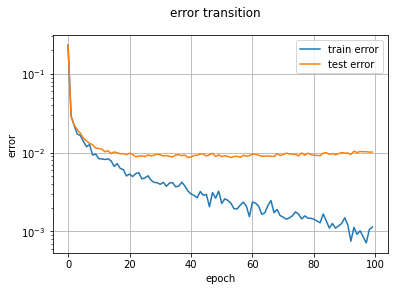

In [41]:
%matplotlib inline
# 畳み込み層と出力層を作成
M, F_h, F_w = 10, 3, 3
lm = LayerManager((x_train, x_test), (t_train, t_test), mode="gpu")
lm.append(name="c", I_shape=(C, I_h, I_w), F_shape=(M, F_h, F_w), pad=1)
lm.append(name="p", I_shape=lm[-1].O_shape, pool=2)
lm.append(name="m", n=100)
lm.append(name="d", ratio=0.5)
lm.append(name="o", n=n_class, act="softmax", err_func="Cross")

# 学習させる
epoch = 100
threshold = 1e-8
n_batch = 128
lm.training(epoch, threshold=threshold, n_batch=n_batch, show_train_error=True)

# 予測する
print("training dataset")
_ = lm.predict(x=lm.x_train, y=lm.y_train)
print("test dataset")
y_pred = lm.predict()

In [37]:
drop_error_list = lm.error_list

In [35]:
err_list = lm.error_list

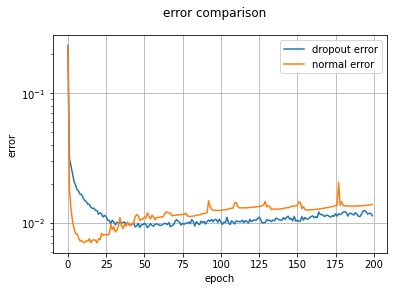

In [38]:
fig, ax = plt.subplots(1)
fig.suptitle("error comparison")
ax.set_xlabel("epoch")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.grid()
ax.plot(drop_error_list, label="dropout error")
ax.plot(err_list, label="normal error")
ax.legend(loc="best")

In [ ]:
|%%timeit
lm.forward(lm.x_train)
error = lm[-1].get_error(lm.y_train)

1 loop, best of 3: 969 ms per loop


In [ ]:
%%timeit
lm.forward(lm.x_test)
error = lm[-1].get_error(lm.y_test)

10 loops, best of 3: 162 ms per loop


In [ ]:
rand_index = np.arange(lm.x_train.get().shape[0])
#rand_index = np.arange(lm.x_train.shape[0])
np.random.shuffle(rand_index)
rand = rand_index[0 : n_batch]

In [ ]:
%%timeit
lm.forward(lm.x_train[rand])

1000 loops, best of 3: 1.72 ms per loop


In [ ]:
%%timeit
lm.backward(lm.y_train[rand])

100 loops, best of 3: 1.65 ms per loop


In [ ]:
err3 = lm[3].backward(lm.y_train[rand])
err2 = lm[2].backward(err3)
err2 = err2.reshape(n_batch, *lm[1].O_shape)
err1 = lm[1].backward(err2)
err0 = lm[0].backward(err1)

In [ ]:
%%timeit
err3 = lm[3].backward(lm.y_train[rand])

The slowest run took 5.09 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 147 µs per loop


In [ ]:
%%timeit
err2 = lm[2].backward(err3)
err2 = err2.reshape(n_batch, *lm[1].O_shape)

10000 loops, best of 3: 224 µs per loop


In [ ]:
%%timeit
err1 = lm[1].backward(err2)

The slowest run took 4.48 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 253 µs per loop


In [ ]:
B, C, O_h, O_w = n_batch, *lm[1].O_shape
grad = err2.transpose(0, 2, 3, 1).reshape(-1, 1)
#grad_x = cp.zeros((grad.size, lm[1].pool*lm[1].pool))
grad_x = np.zeros((grad.size, lm[1].pool*lm[1].pool))
grad_x1 = grad_x.copy()
grad_x1 = lm[1].max_index*grad
grad_x2 = grad_x1.reshape(B*O_h*O_w, C*lm[1].pool*lm[1].pool).T

In [ ]:
%%timeit
grad = err2.transpose(0, 2, 3, 1).reshape(-1, 1)

The slowest run took 35.53 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 17.1 µs per loop


In [ ]:
%%timeit
grad_x = cp.zeros((grad.size, lm[1].pool*lm[1].pool))

The slowest run took 98.85 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 8.49 µs per loop


In [ ]:
%%timeit
grad_x1 = lm[1].max_index*grad

The slowest run took 22.78 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 11.6 µs per loop


In [ ]:
%%timeit
grad_x2 = grad_x1.reshape(B*O_h*O_w, C*lm[1].pool*lm[1].pool).T

The slowest run took 13.62 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.76 µs per loop


In [ ]:
%%timeit
grad_x3 = col2im(lm.calculator, grad_x2,
                 (n_batch, *lm[1].I_shape), lm[1].O_shape,
                 stride=lm[1].pool, pad=lm[1].pad_state)

The slowest run took 5.56 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 194 µs per loop


In [ ]:
%%timeit
err0 = lm[0].backward(err1)

The slowest run took 6.61 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 851 µs per loop


In [ ]:
%%timeit
lm.update()

1000 loops, best of 3: 1.61 ms per loop


incorrect index: [ 151  247  259  321  340  445  582  619  655  659  684  717  740  813
  882  947  956  965 1014 1039 1044 1112 1182 1226 1232 1242 1247 1260
 1319 1326 1364 1378 1393 1522 1530 1549 1553 1621 1678 1709 1717 1754
 1790 1901 1938 1984 2004 2035 2043 2070 2098 2118 2130 2135 2182 2272
 2293 2329 2387 2406 2454 2462 2488 2607 2635 2648 2654 2758 2760 2836
 2850 2882 2896 2927 2930 2939 2979 2995 3060 3422 3520 3550 3558 3559
 3597 3604 3718 3726 3727 3751 3808 3902 3906 3941 3976 4027 4065 4075
 4078 4163 4224 4248 4269 4344 4369 4380 4443 4497 4536 4547 4639 4671
 4690 4761 4783 4807 4814 4823 4874 4956 4966 5331 5600 5676 5734 5736
 5746 5749 5887 5937 5973 6071 6166 6168 6173 6532 6555 6571 6574 6576
 6577 6597 6625 6632 6755 6783 7091 7434 7472 7736 7849 8094 8311 8325
 8408 8504 8849 9009 9015 9019 9024 9280 9540 9587 9634 9642 9664 9692
 9698 9700 9729 9741 9745 9749 9768 9770 9782 9839 9879]


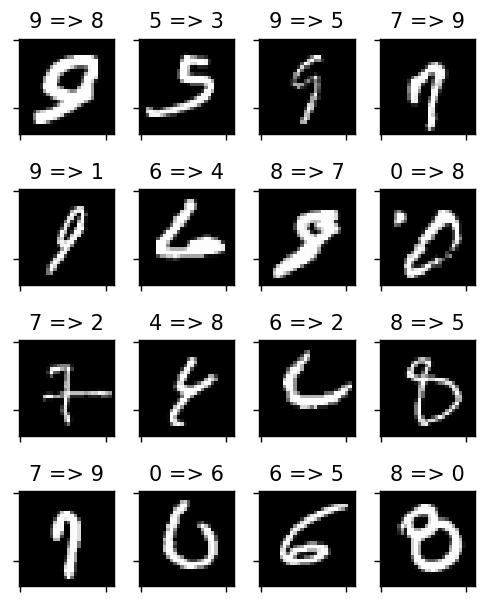

In [ ]:
# 間違ったデータを表示する
col=4
dpi=125
if lm.mode == "cpu":
    x = lm.x_test*sc.var_.reshape(1, I_h, I_w)**0.5 + sc.mean_.reshape(1, I_h, I_w)
    y = lm.pred_func(lm.y_test)
elif lm.mode == "gpu":
    x = (lm.x_test.get()*sc.var_.reshape(1, I_h, I_w)**0.5 
         + sc.mean_.reshape(1, I_h, I_w))
    y = lm.pred_func(lm.y_test).get()
fail_index = np.where(y_pred != y)[0]
print("incorrect index:", fail_index)
if fail_index.size:
    n_image = min(16, fail_index.size)
    np.random.shuffle(fail_index)
    row = int(np.ceil(n_image/col))
    if row * dpi >= 2 ** 16:
        row = int(np.ceil((2 ** 16 // dpi - 1)/col))
    fig, ax = plt.subplots(row, col, figsize=(col, row + 1), dpi=dpi, facecolor="w")
    if row != 1:
        for i, f in enumerate(fail_index):
            ax[i // col, i % col].imshow(x[f].reshape(I_h, I_w), interpolation='nearest', cmap='gray')
            ax[i // col, i % col].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            ax[i // col, i % col].set_title(str(y[f]) + " => " + str(y_pred[f]))
            if i >= row * col - 1:
                break
    else:
        for i, f in enumerate(fail_index):
            ax[i % col].imshow(x[f].reshape(I_h, I_w), interpolation='nearest', cmap='gray')
            ax[i % col].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            ax[i % col].set_title(str(y[f]) + ' => ' + str(y_pred[f]))
            if i >= row * col - 1:
                break
    fig.tight_layout()
    fig.savefig("incorrect.png")

In [ ]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''
 
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
 
batch_size = 128
num_classes = 10
epochs = 12
 
# input image dimensions
img_rows, img_cols = 28, 28
 
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
 
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
 
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
 
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/12
469/469 [==============================] - 3s 6ms/step - loss: 2.2813 - accuracy: 0.1508 - val_loss: 2.2545 - val_accuracy: 0.3248
Epoch 2/12
469/469 [==============================] - 3s 6ms/step - loss: 2.2365 - accuracy: 0.2631 - val_loss: 2.1975 - val_accuracy: 0.4786
Epoch 3/12
469/469 [==============================] - 3s 6ms/step - loss: 2.1741 - accuracy: 0.3563 - val_loss: 2.1153 - val_accuracy: 0.5467
Epoch 4/12
469/469 [==============================] - 3s 6ms/step - loss: 2.0854 - accuracy: 0.4355 - val_loss: 1.9987 - val_accuracy: 0.6086
Epoch 5/12
469/469 [==============================] - 3s 6ms/step - loss: 1.9614 - accuracy: 0.4915 - val_loss: 1.8392 - val_accuracy: 0.6701
Epoch 6/12
469/469 [==============================] - 3s 6ms/step - loss: 1.8031 - accuracy: 0.5449 - val_loss: 1.6407 - val_accuracy: 0.7154
Epoch 7/12
469/469 [==============================] - 3s 6ms/step - loss: 1